# Quadrant kaleidoscope

Existing kaleidoscope implementation in 8.0 stil uses input from -1 to 1, then has it reflected into three more quadrants. Since the current implementation explicitly takes distance to origin, the kaleidoscope effect does not look centered. To make it centered, need to implement the input to the CPPN differently.

From studying the code base, looks like I can do this by introducing more parametrization to `create_input` in `art.py`.

In [18]:
from art import Net

In [28]:
import torch
import numpy as np
from typing import Dict, Any, NoReturn
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def create_input(
    img_width: int, img_height: int,
    include_dist_to_origin: bool = True,
    xs_start: float = -1, xs_stop: float = 1,
    ys_start: float = -1, ys_stop: float = 1
) -> np.ndarray:
    """
    Creates the input for the generative net.

    Input
    -----
    img_width, img_height: int
    include_dist_to_origin: bool

    Output
    ------
    input_arr: np.ndarray
        Should have shape (img_width * img_height, 2)
    """
    # Create vectors of xs and ys
    xs = np.linspace(start=xs_start, stop=xs_stop, num=img_width)
    ys = np.linspace(start=ys_start, stop=ys_stop, num=img_height)

    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)

    if include_dist_to_origin:
        dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)
        input_arr = np.concatenate([input_arr, dist_to_origin], axis=2)
        input_arr = input_arr.reshape(img_width * img_height, 3)
    else:
        input_arr = input_arr.reshape(img_width * img_height, 2)

    return input_arr

In [23]:
# Copypasting here so uses fxn in notebook
def generate_one_art(
    net: Net,
    latent_vec: torch.Tensor,
    input_config: Dict[str, Any] = {"img_width": 320, "img_height": 320},
) -> np.ndarray:
    """
    Wrapper function to generate a single image output from the given network.

    Input
    -----
    net: Net
    latent_vec: torch.Tensor
    input_config: dict
        Dict of parameters to be passed to `create_input` as kwargs.

    Output
    ------
    net_output: np.ndarray
        Should have shape (y, x, 3) or (y, x, 1)
    """
    # Create input to net, and convert from ndarray to torch.FloatTensor
    net_input = torch.tensor(create_input(**input_config)).float()

    # Create input array from latent_vec, and convert from ndarray to torch.FloatTensor
    latent_vec = np.expand_dims(latent_vec, axis=0)
    latent_vec = np.repeat(latent_vec, repeats=net_input.shape[0], axis=0)
    latent_vec = torch.tensor(latent_vec).float()

    # This logic is wrong!
    # assert net_input.shape == latent_vec.shape, (
    #     "Shape of net_input is "
    #     f"{net_input.shape} while shape of latent_vec is {latent_vec.shape}"
    # )

    # Run input through net
    net_output = net(net_input, latent_vec).detach().numpy()

    # Reshape into (y, x, 3) for plotting in PIL
    net_output = net_output.reshape(
        input_config["img_height"], input_config["img_width"], -1
    )

    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output

In [24]:
# Copypasting here so that it uses fxn in notebook
def generate_one_gallery(
    net_config: Dict[str, Any] = {
        "num_hidden_layers": 4,
        "num_neurons": 8,
        "include_bias": True,
    },
    input_config: Dict[str, Any] = {"img_width": 320, "img_height": 320},
) -> NoReturn:
    """
    Plots grid of 40 images, accepting net_config as dict containing parameters to Net constructor.
    From these images, the ones in a column are the same network but have their latent vector perturbed.

    Input
    -----
    net_config: dict
        Dict of parameters to be passed to `Net()` as kwargs.

    input_config: dict
        Dict of parameters to be passed to `create_input` through `generate_one_art` as kwargs.

    Output
    ------
    None
    """
    _, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))

    for i in range(10):
        net = Net(**net_config)
        latent_vec = np.random.normal(size=(3,))

        for j in range(4):
            out = generate_one_art(
                net, latent_vec=latent_vec, input_config=input_config
            )
            latent_vec += 0.2

            # if (n, n, 1) output i.e. if grayscale
            if out.shape[2] == 1:
                img = Image.fromarray(
                    np.squeeze(out), mode="L"
                )  # Mode inference is automatic but better be explicit
                ax[j, i].imshow(img, cmap="gray")
            else:
                img = Image.fromarray(out, mode="RGB")
                ax[j, i].imshow(img, cmap="gray")

            ax[j, i].xaxis.set_visible(False)
            ax[j, i].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()


In [38]:
net = Net(num_neurons=32)

In [39]:
latent_vec = np.random.standard_normal(size=(3,))

In [47]:
topleft = generate_one_art(net, latent_vec, input_config={
    "xs_start":-1, "xs_stop":0,
    "ys_start":-1, "ys_stop":0,
    "img_width": 640, "img_height": 320
})

In [48]:
wholeimg = generate_one_art(net, latent_vec, input_config={
    # "xs_start":-1, "xs_stop":1,
    # "ys_start":-1, "ys_stop":1,
    "img_width": 640, "img_height": 320
})

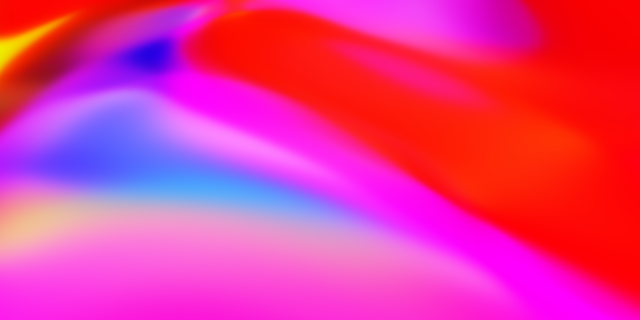

In [49]:
Image.fromarray(topleft)

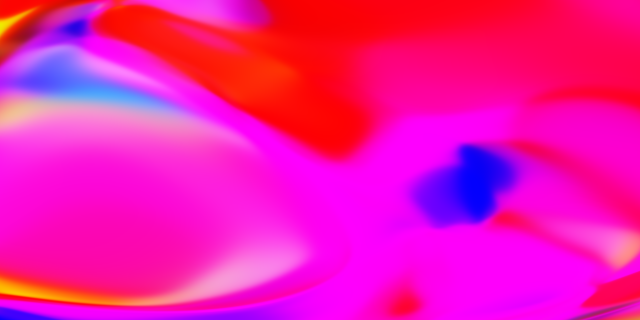

In [50]:
Image.fromarray(wholeimg)

Good. Now to implement this change and see it in action. 